In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF Solar and Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF Solar and Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to WRF data file
datapath = os.path.join(pvlib_abspath, 'data', 'wrfout_d01_2011-01-24_01:00:00')

# Read in the wrfout file using the netCDF4.Dataset method (I think you can also do this with an xarray method)
netcdf_data = netCDF4.Dataset(datapath)

In [3]:
# Create an xarray.Dataset from the wrf qurery_variables.
query_variables = [
            'Times',
            'T2',
            'U10',
            'V10',
            'SWDDNI',
            'SWDDIF'
            ]
first = True
for key in query_variables:
    var = getvar(netcdf_data, key, timeidx=ALL_TIMES)
    if first:
        solar_data = var
        first = False
    else:
        solar_data = xr.merge([solar_data, var])

variables = {
            'times': 'times',
            'XLAT': 'lat',
            'XLONG': 'lon',
            'T2': 'temp_air',
            'U10': 'wind_speed_u',
            'V10': 'wind_speed_v',
            'SWDDNI': 'dni',
            'SWDDIF': 'dhi' 
            }
solar_data = xr.Dataset.rename(solar_data, variables)
solar_data = xr.Dataset.reset_coords(solar_data, ['XTIME'], drop=True)
times = solar_data.times
solar_data = xr.Dataset.set_coords(solar_data, ['times'])
solar_data = xr.Dataset.reset_coords(solar_data, ['times'], drop=True)
ntimes = solar_data.sizes['Time']
nlat = solar_data.sizes['south_north']
nlon = solar_data.sizes['west_east']
solar_data

<xarray.Dataset>
Dimensions:       (Time: 24, south_north: 191, west_east: 191)
Coordinates:
  * Time          (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    lon           (south_north, west_east) float32 -95.43335 ... -64.11832
    lat           (south_north, west_east) float32 30.952759 ... 47.507103
Dimensions without coordinates: south_north, west_east
Data variables:
    temp_air      (Time, south_north, west_east) float32 287.62427 ... 264.03226
    wind_speed_u  (Time, south_north, west_east) float32 0.31499797 ... 17.972435
    wind_speed_v  (Time, south_north, west_east) float32 1.1208413 ... -1.0850167
    dni           (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    dhi           (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0

In [4]:
# Explore how the WRF forecast model behaves
fm = WRF()
wind_speed = fm.uv_to_speed(solar_data)
temp_air = fm.kelvin_to_celsius(solar_data['temp_air'])

In [5]:
# Convert xarray Datasets to a pandas DataFrames
solar_data = solar_data.to_dataframe()
times = times.to_dataframe()
solar_data

lon        lat    temp_air  \
Time                south_north west_east                                     
2011-01-24 01:00:00 0           0         -95.433350  30.952759  287.624268   
                                1         -95.308044  30.950832  287.592499   
                                2         -95.182739  30.948757  287.163452   
                                3         -95.057465  30.946545  287.356171   
                                4         -94.932190  30.944153  287.152344   
...                                              ...        ...         ...   
2011-01-25 00:00:00 190         186       -64.714050  47.657688  263.186615   
                                187       -64.564850  47.620308  262.584229   
                                188       -64.415833  47.582741  263.205566   
                                189       -64.266968  47.545010  263.703674   
                                190       -64.118317  47.507103  264.032257   

                                           wind_speed_u  wind_speed_v  dni  \
Time                south_north west_east                                    
2011-01-24 01:00:00 0           0              0.314998      1.120841  0.0   
                                1             -0.087709      1.663511  0.0   
                                2             -0.358935      1.999503  0.0   
                                3             -0.632014      2.513421  0.0   
                                4             -0.803844      2.692272  0.0   
...                                                 ...           ...  ...   
2011-01-25 00:00:00 190         186           15.262465     -0.319409  0.0   
                                187           15.590679     -0.548230  0.0   
                                188           16.902138     -0.615797  0.0   
                                189           17.802485     -0.596332  0.0   
                                190           17.972435     -1.085017  0.0   

                                           dhi  
Time                south_north west_east       
2011-01-24 01:00:00 0           0          0.0  
                                1          0.0  
                                2          0.0  
                                3          0.0  
                                4          0.0  
...                                        ...  
2011-01-25 00:00:00 190         186        0.0  
                                187        0.0  
                                188        0.0  
                                189        0.0  
                                190        0.0  

[875544 rows x 7 columns]

/Users/swardy9230/opt/anaconda3/envs/wrfplot2/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/swardy9230/opt/anaconda3/envs/wrfplot2/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


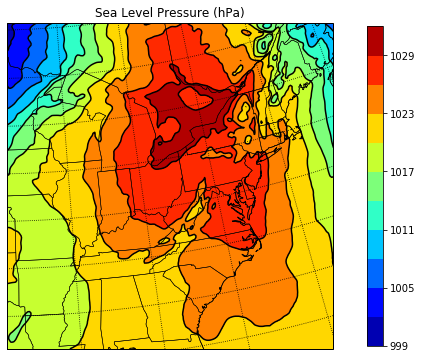

In [6]:
# Open the NetCDF file
ncfile = netcdf_data

# Get the sea level pressure
slp = getvar(ncfile, "slp")

# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(smooth_slp), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

plt.show()